# Expedia Hotel Recommendations

### Group Members:
1. Ishita Agarwal
2. Hiral Patel
3. Sanjana Shashikanth

### Project Description
This is a past competition on Kaggle. The main problem statement is to provide personalized hotel recommendations to Expedia users. Expedia has grouped hotels into clusters depending on some features. Currently Expedia uses search filters to suggest hotels to a user but going forward they want to provide personalized recommendations. But they do not have enough customer centric points to personalize data. Hence the main challenge here is to contextualize the current data to find out and predict the probability of a customer staying at a particular group of hotel.

In [21]:
import pandas as pd 
from sklearn.decomposition import PCA

In [22]:
train = pd.read_csv("/Users/Ishita/Documents/input/train.csv",parse_dates=['srch_ci', 'srch_co'])
print("new",train.shape)

new (37670293, 24)


In [16]:
#Loading the Test data file
test = pd.read_csv("/Users/Ishita/Documents/input/test.csv")
print (test.shape)

(2528243, 22)


In [3]:
#loading the destination file
destinations = pd.read_csv("/Users/Ishita/Documents/input/destinations.csv")
print (destinations.shape)

(62106, 150)


In [4]:
#Randomly Picking 10000 users
import random

unique_users = train.user_id.unique()

sel_user_ids = [unique_users[i] for i in sorted(random.sample(range(len(unique_users)), 10000)) ]
sel_train = train[train.user_id.isin(sel_user_ids)]

#Removing the click events if is_booking is 0 it represents a click
sel_train = sel_train[train.is_booking == True]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
# Adding times and dates. Making it easier to work with date
print (sel_train.shape)
sel_train["date_time"] = pd.to_datetime(sel_train["date_time"])
sel_train["year"] = sel_train["date_time"].dt.year
sel_train["month"] = sel_train["date_time"].dt.month

(25420, 24)


In [6]:
#Generating features from the destination. Compressing the 149 cloumns in the destination file to 3 columns
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = destinations["srch_destination_id"]
print (dest_small.shape)

(62106, 4)


In [14]:
#Generating Features :
#Generating new date features based on date_time, srch_ci, and srch_co
#Remove non-numeric columns like date_time 
#Add in features from dest_small i.e. add features in destination.csv
#Replace any missing values with -1
def calc_fast_features(df):
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    df["date_time"] = pd.to_datetime(df["date_time"])
    
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    # creatinf new column "stay_span" which shows number of nights user searches
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

df = calc_fast_features(sel_train)
#df.describe()
# filling missing values with -1 for now, further improvements can be made when we start training the algorithm
df.fillna(-1, inplace=True)
df.describe()
# dropping the user id column as it will not be a relevant feature
df=df.drop(["user_id"], axis=1)
print (df.shape)
print (list(df.columns.values))

(25420, 39)
['channel', 'ci_day', 'ci_dayofweek', 'ci_month', 'ci_quarter', 'cnt', 'co_day', 'co_dayofweek', 'co_month', 'co_quarter', 'day', 'dayofweek', 'hotel_cluster', 'hotel_continent', 'hotel_country', 'hotel_market', 'hour', 'is_booking', 'is_mobile', 'is_package', 'minute', 'month', 'orig_destination_distance', 'posa_continent', 'quarter', 'site_name', 'srch_adults_cnt', 'srch_children_cnt', 'srch_destination_id', 'srch_destination_type_id', 'srch_rm_cnt', 'stay_span', 'user_location_city', 'user_location_country', 'user_location_region', 'year', 0, 1, 2]


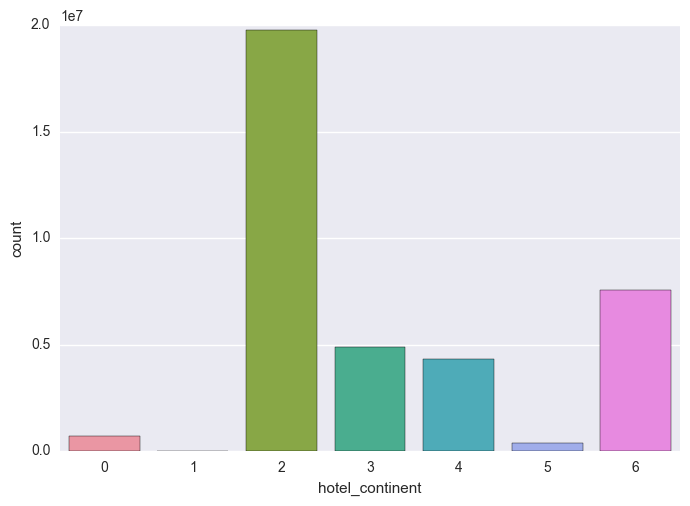

In [19]:
# preferred continent destinations
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.show()
sns.countplot(x='hotel_continent', data=train)

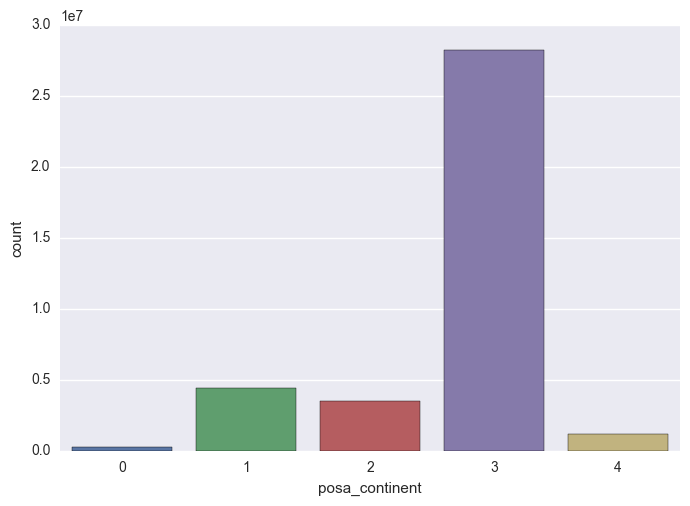

In [20]:
# most of people booking are from continent 3 I guess is one of the rich continent?
sns.countplot(x='posa_continent', data=train)

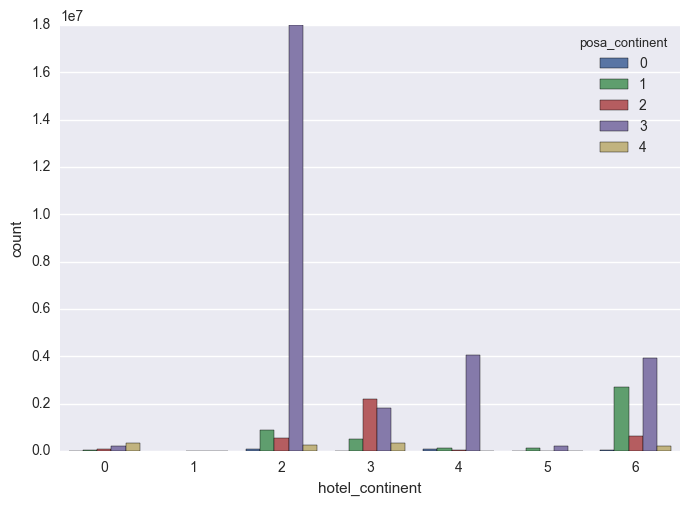

In [22]:
# putting the two above together
sns.countplot(x='hotel_continent', hue='posa_continent', data=train)

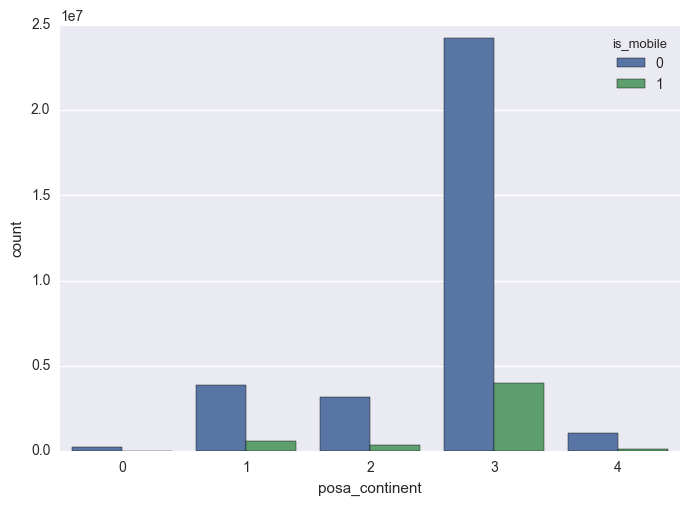

In [23]:
# how many people by continent are booking from mobile
sns.countplot(x='posa_continent', hue='is_mobile', data = train)

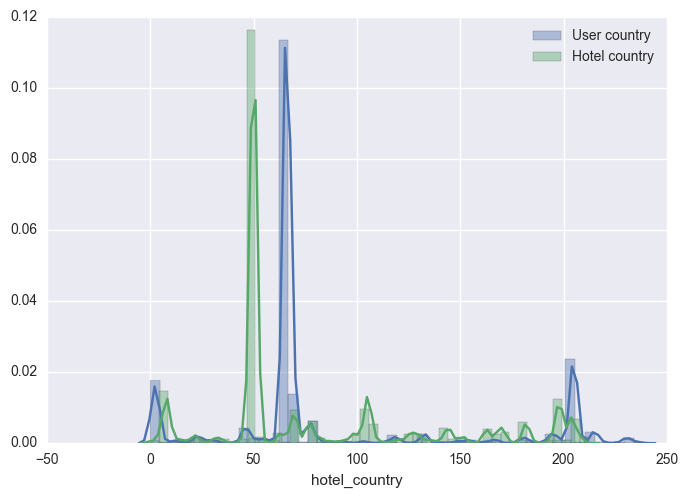

In [26]:
# Difference between user and destination country
sns.distplot(train['user_location_country'], label="User country")
sns.distplot(train['hotel_country'], label="Hotel country")
plt.legend()

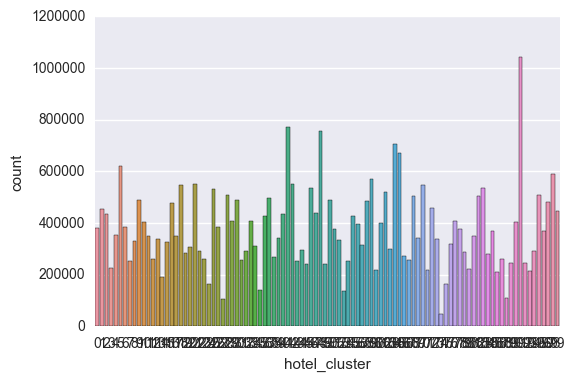

In [23]:
#visualising target variable
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='hotel_cluster', data=train)

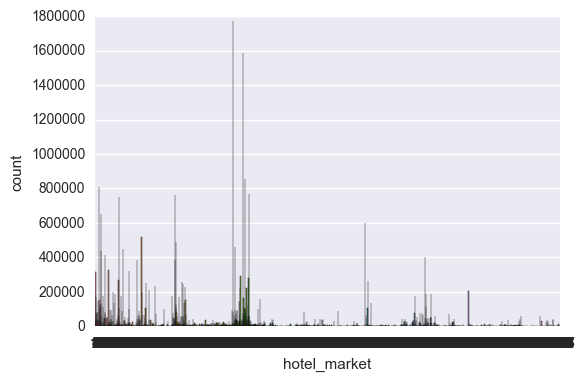

In [24]:
sns.countplot(x='hotel_market', data=train)

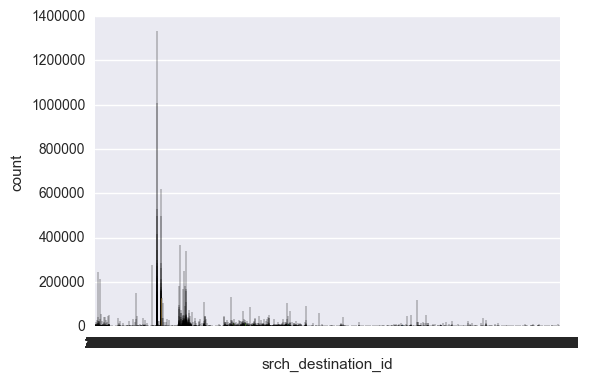

In [25]:
sns.countplot(x='srch_destination_id', data=train)

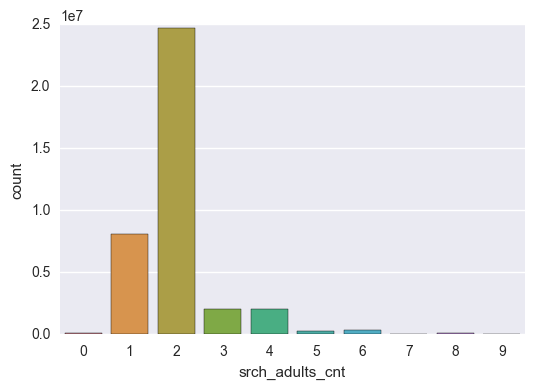

In [26]:
sns.countplot(x='srch_adults_cnt', data=train)

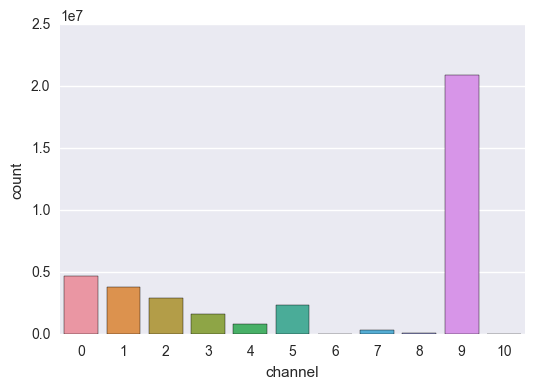

In [27]:
sns.countplot(x='channel', data=train)

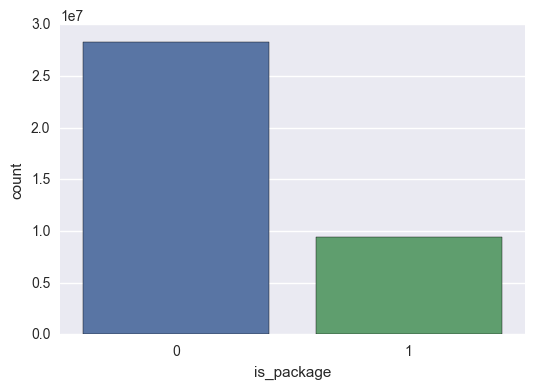

In [28]:
sns.countplot(x='is_package', data=train)

i am done


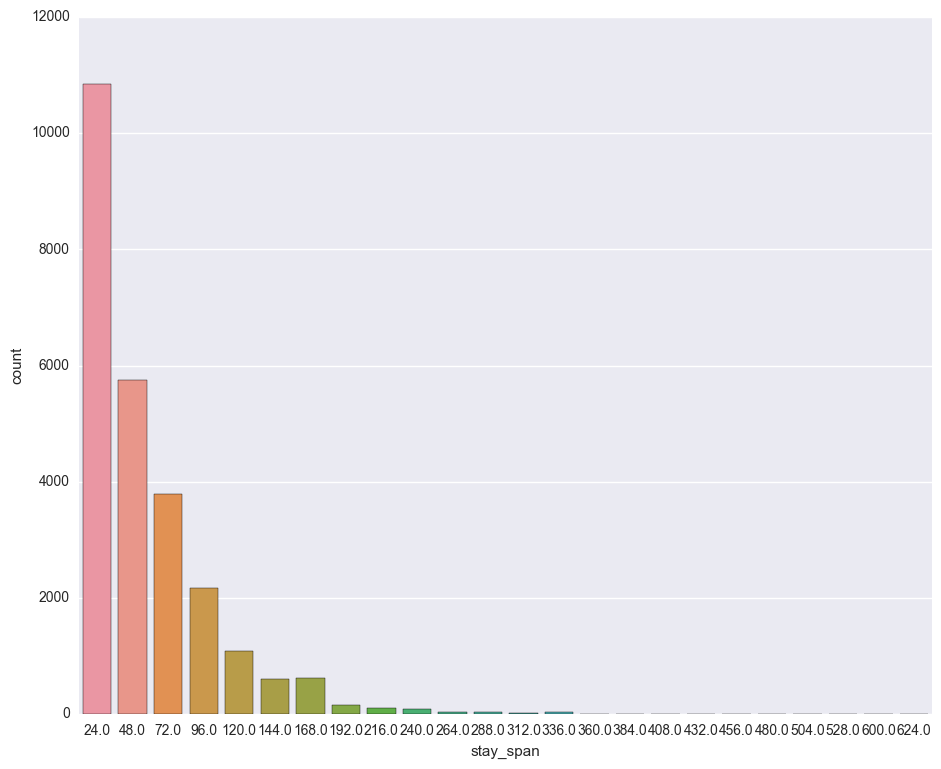

In [10]:
#Nights spend in a Hotel
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(11, 9))
sns.countplot(x="stay_span",label="Nights spend in a Hotel", data=df)
#print("i am done")

In [11]:
#statistics of all the features in original dataset
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,2.414529e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,...,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07
mean,9.795271e+00,2.680473e+00,8.610880e+01,3.084060e+02,2.775304e+04,1.970090e+03,6.044518e+05,1.349265e-01,2.489042e-01,5.870761e+00,...,3.321222e-01,1.112663e+00,1.444109e+04,2.582280e+00,7.965675e-02,1.483384e+00,3.156305e+00,8.129685e+01,6.004619e+02,4.980861e+01
std,1.196754e+01,7.480393e-01,5.924310e+01,2.084437e+02,1.678255e+04,2.232442e+03,3.506175e+05,3.416451e-01,4.323782e-01,3.717095e+00,...,7.314981e-01,4.591155e-01,1.106630e+04,2.153019e+00,2.707611e-01,1.219776e+00,1.623189e+00,5.617119e+01,5.117391e+02,2.891595e+01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.300900e+04,3.131670e+02,2.989100e+05,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,1.600000e+02,2.500000e+01
50%,2.000000e+00,3.000000e+00,6.600000e+01,3.140000e+02,2.765500e+04,1.140491e+03,6.039140e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,9.147000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,5.930000e+02,4.900000e+01
75%,1.400000e+01,3.000000e+00,7.000000e+01,3.850000e+02,4.241300e+04,2.552599e+03,9.101680e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,1.879000e+04,5.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,1.060000e+02,7.010000e+02,7.300000e+01
max,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650800e+04,1.240790e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,...,9.000000e+00,8.000000e+00,6.510700e+04,9.000000e+00,1.000000e+00,2.690000e+02,6.000000e+00,2.120000e+02,2.117000e+03,9.900000e+01
